<a href="https://colab.research.google.com/github/asoushawk/octopusguesser/blob/master/prediction_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
%tensorflow_version 2.x

In [15]:
!pip install -q sklearn

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [111]:
# Load dataset.
dftrain = pd.read_csv('http://unes.epizy.com/7.csv') # training data
dfeval = pd.read_csv('http://unes.epizy.com/9.csv') # testing data
y_train = dftrain.pop('winner')
print(dftrain.head())
y_eval = dfeval.pop('winner')
print(dftrain.head())


  top_red_champion  ...  sup_blue_champion_kda
0            Urgot  ...               4.366667
1            Riven  ...               5.083333
2        Gangplank  ...              10.273469
3             Sett  ...               4.045455
4           Irelia  ...               6.676471

[5 rows x 30 columns]
  top_red_champion  ...  sup_blue_champion_kda
0            Urgot  ...               4.366667
1            Riven  ...               5.083333
2        Gangplank  ...              10.273469
3             Sett  ...               4.045455
4           Irelia  ...               6.676471

[5 rows x 30 columns]


In [112]:
CATEGORICAL_COLUMNS = [
"top_red_champion", 
"top_blue_champion",
"jg_red_champion",
"jg_blue_champion", 
"mid_red_champion", 
"mid_blue_champion",
"adc_red_champion", 
"adc_blue_champion",
"sup_red_champion", 
"sup_blue_champion"]
NUMERIC_COLUMNS = ["top_red_rota_champion_month", "top_red_champion_kda", 
"top_blue_rota_champion_month", "top_blue_champion_kda", 
"jg_red_rota_champion_month",  "jg_red_champion_kda", 
"jg_blue_rota_champion_month",  "jg_blue_champion_kda", 
"mid_red_rota_champion_month", "mid_red_champion_kda", 
"mid_blue_rota_champion_month",  "mid_blue_champion_kda",
"adc_red_rota_champion_month",  "adc_red_champion_kda",
"adc_blue_rota_champion_month",  "adc_blue_champion_kda",
"sup_red_rota_champion_month",  "sup_red_champion_kda",
"sup_blue_rota_champion_month",  "sup_blue_champion_kda"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(list(feature_columns[1]))

['top_blue_champion', ('Shaco', 'Urgot', 'Renekton', 'Gnar', 'Gangplank', 'Nocturne', 'Illaoi', 'Singed', 'Pantheon', 'Riven', 'Dr. Mundo', 'Kennen', 'Akali', 'Camille', 'Garen', 'Irelia', 'Jhin', 'Rumble', 'Ezreal', 'Sett', 'Darius', 'Tryndamere', 'Teemo', 'Shen', 'Nasus', 'Sion', 'Aatrox', 'Jax', 'Graves', "Cho'Gath", 'Rengar', 'Fiora', 'Yone', 'Zed', 'Yasuo', 'Ahri', 'Azir', 'Varus', 'Caitlyn', 'Volibear'), tf.string, -1, 0]


In [71]:
dftrain.head()

,top_red_champion,top_red_rota_champion_month,top_red_champion_kda,top_blue_champion,top_blue_rota_champion_month,top_blue_champion_kda,jg_red_champion,jg_red_rota_champion_month,jg_red_champion_kda,jg_blue_champion,jg_blue_rota_champion_month,jg_blue_champion_kda,mid_red_champion,mid_red_rota_champion_month,mid_red_champion_kda,mid_blue_champion,mid_blue_rota_champion_month,mid_blue_champion_kda,adc_red_champion,adc_red_rota_champion_month,adc_red_champion_kda,adc_blue_champion,adc_blue_rota_champion_month,adc_blue_champion_kda,sup_red_champion,sup_red_rota_champion_month,sup_red_champion_kda,sup_blue_champion,sup_blue_rota_champion_month,sup_blue_champion_kda
0,Urgot,62.0,7.412500,Shaco,49.3,7.933333,Kayn,48.1,11.673810,Zac,83.3,17.000000,Annie,59.7,13.425424,Sett,68.4,13.425424,Jhin,61.5,11.273770,Vayne,50.0,9.285714,Thresh,64.0,6.000000,Nami,55.2,4.366667
1,Riven,50.4,9.553125,Urgot,62.0,7.412500,Graves,55.6,8.962500,Volibear,56.5,12.971429,Malphite,66.7,9.285714,Irelia,53.8,9.285714,Caitlyn,57.9,9.750000,Ashe,55.8,6.200000,Nami,46.2,7.814815,Lulu,50.0,5.083333
2,Gangplank,57.1,8.448780,Urgot,62.0,7.412500,Graves,58.8,4.188889,Kha'Zix,54.4,9.544444,Yasuo,58.9,9.285714,Renekton,80.0,9.285714,Caitlyn,44.4,7.033333,Swain,75.0,6.084615,Lulu,58.6,7.000000,Senna,37.5,10.273469
3,Sett,59.8,10.828571,Urgot,62.0,7.412500,Kayn,61.1,14.800000,Shaco,55.8,10.494444,Akali,56.4,14.510526,Yone,46.7,14.510526,Caitlyn,48.0,4.000000,Ashe,57.5,5.250000,Twitch,57.1,10.625000,Leona,56.7,4.045455
4,Irelia,52.1,8.041379,Renekton,62.0,8.050000,Lee Sin,37.5,9.771429,Warwick,34.1,10.442857,Ahri,50.0,0.714286,Lux,50.0,0.714286,Jinx,75.0,11.181818,Ezreal,56.3,9.879545,Jhin,50.0,7.500000,Zyra,62.5,6.676471


input function

In [113]:
def make_input_fn(data_df, label_df, num_epochs=30, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(2000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [99]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbfhqp454', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [116]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.71428573


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaznyfuwy/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


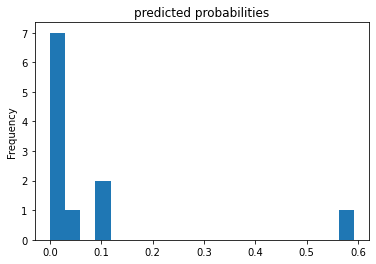

In [10]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [143]:
result = list(linear_est.predict(eval_input_fn))

p = -1
for i in range(14):
  p = p+1
  print("Match ID:", p)
  print(result[p]['probabilities'][0],"Chance do time vermelho ter vencido")
  print(result[p]['probabilities'][1],"Chance do time azul ter vencido")




  






INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbfhqp454/model.ckpt-360
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Match ID: 0
0.9830451 Chance do time vermelho ter vencido
0.016954884 Chance do time azul ter vencido
Match ID: 1
0.3199417 Chance do time vermelho ter vencido
0.68005836 Chance do time azul ter vencido
Match ID: 2
3.60321e-06 Chance do time vermelho ter vencido
0.9999964 Chance do time azul ter vencido
Match ID: 3
0.039833795 Chance do time vermelho ter vencido
0.96016616 Chance do time azul ter vencido
Match ID: 4
0.20453063 Chance do time vermelho ter vencido
0.7954694 Chance do time azul ter vencido
Match ID: 5
0.069074646 Chance do time vermelho ter vencido
0.9309253 Chance do time azul ter vencido
Match ID: 6
0.9819833 Chance do time vermelho ter vencido
0.018016674 Chance do time azul ter vencido
Match ID: 7
0.9813234 Chance do time vermelho ter venc